# Online learning with Orthonormal Certificates

In [1]:
import numpy as np 
from tqdm import tqdm
from typeguard import typechecked

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

## Data functions

$$
y = A \sin (wt + \phi ) + \eta
$$
* A is amplitude
* $\phi$ is phase of the wave
* w is the angular frequancy of the wave
* t is time period
* eta is noise value from standard normal

In [2]:
def sineWave(a,b,n=100,A=1,w=0,phi=0,eta=0):
    """
    a float: starting point
    b float: end point
    n int: number of samples 
    A float: amplitude of sine wave
    w float: angular frequancy 
    phi float: phase of wave
    eta float: standard deviation of normal for noise
    """
    x = np.linspace(a,b,n)
    y = A*np.sin(w*x+phi)
    y = y+np.random.normal(0,eta,n)
    return x,y

In [3]:
x0, y0 = sineWave(0,10,100,10,2,0,2)

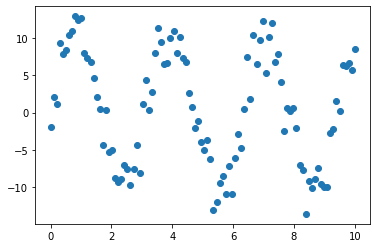

In [4]:
plt.scatter(x0,y0)

In [5]:
def linear(a,b,n,m,h,eta=0):
    """
    a float: starting point
    b float: end point
    n int: number of samples 
    m float: slope of line 
    h : y-intercept of line
    eta float: standard deviation of normal for noise
    """
    x = np.linspace(a,b,n)
    y = m*x+h
    y = y+np.random.normal(0,eta,n)
    return x,y

In [6]:
x1, y1 = linear(10,20,100,0,10,eta=.1)

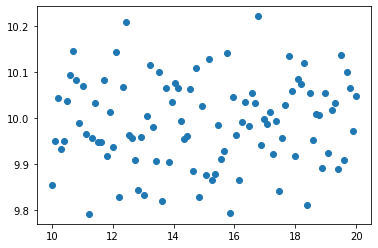

In [7]:
plt.scatter(x1,y1)

In [8]:
X,y = np.concatenate((x0,x1),axis=0),np.concatenate((y0,y1),axis=0)

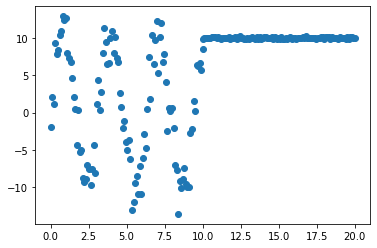

In [9]:
plt.scatter(X,y)

## Build data set

In [10]:
Ax, Ay = sineWave(0,50,100,A=.5,w=10,phi=2,eta=.01)
Bx, By = sineWave(0,50,100,A=-1,w=1,phi=3,eta=.01)
Cx, Cy = linear(0,50,100,.05,0,eta=.03)
Dx, Dy = linear(0,50,100,-.05,5,eta=.02)
Ex, Ey = sineWave(0,50,100,A=.3,w=4,phi=2,eta=.01)
Fx, Fy = linear(0,50,100,0,1,eta=.01)
Gx, Gy = linear(0,50,100,0,1,eta=.01)

In [11]:
y = np.concatenate((Ay, By, Cy, Dy, Ey, Fy, Gy), axis=0)
X = range(0,y.shape[0])

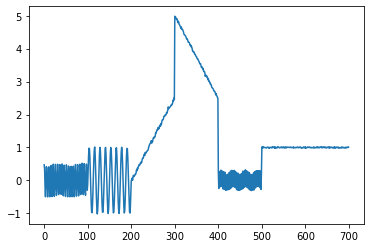

In [12]:
plt.plot(X,y)

In [13]:
y = np.concatenate((y,y,y,y,y), axis=0)
X = range(0,y.shape[0])

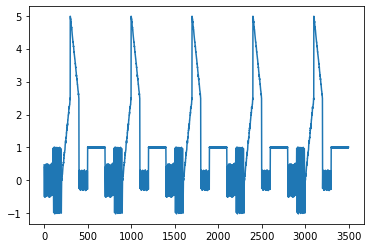

In [14]:
plt.plot(X,y)

### Test set

In [15]:
Ax, Ay = sineWave(0,50,100,A=.5,w=10,phi=2,eta=.01)
Bx, By = sineWave(0,50,100,A=5,w=50,phi=2,eta=.04)
Cx, Cy = linear(0,50,100,.05,-20,eta=.03)
Dx, Dy = linear(0,50,100,2,-10,eta=0)
Ex, Ey = sineWave(0,50,100,A=.3,w=4,phi=2,eta=.01)
Fx, Fy = linear(0,50,100,-1,-50,eta=0)
Gx, Gy = linear(0,50,100,0,20,eta=.01)
Hx, Hy = sineWave(0,50,100,A=5,w=50,phi=2,eta=.01)

In [16]:
y_test = np.concatenate((Ay, By, Cy, Dy, Ey, Fy, Gy, Hy), axis=0)
X_test = range(0,y_test.shape[0])

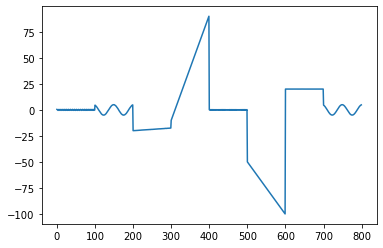

In [17]:
plt.plot(X_test,y_test)

## Train LSTM

### Layers

In [18]:
class LN_GRUCell(Layer):
    """ Custom GRU cell where layer normalization is applied at each state """
    def __init__(self,units,activation='tanh',**kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_gru_cell = tf.keras.layers.GRUCell(units,activation=None,kernel_regularizer=\
            regularizers.l1_l2(l1=1e-3, l2=1e-3),bias_regularizer=regularizers.l2(1e-3),\
            dropout=.15,recurrent_dropout=.15)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call (self,inputs,states):
        outputs, new_states = self.simple_gru_cell(inputs,states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs , [ norm_outputs ]

### Declare model

In [19]:
time_steps = 15 # How many samples goes into a sequence forming one input value
n_input_features = 1 

In [20]:
i = Input(shape=(time_steps,n_input_features))
x = RNN(LN_GRUCell(128),return_sequences = False)(i)
x = LayerNormalization()(x)
x = Dense(64,activation="swish",kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),\
        bias_regularizer=regularizers.l2(1e-3))(x)
x = LayerNormalization()(x)
x = Dropout(.1)(x)
output = Dense(1,activation="linear",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5),\
        bias_regularizer=regularizers.l2(1e-5))(x)

model = Model(i, output)
opt = RMSprop(.0001)
model.compile(loss='mean_squared_error',metrics=['mse'], optimizer=opt)

### Declare data generator

In [21]:
train_x = y[:-15]/3 
train_y = y[15:]/3
print(train_x.shape,train_y.shape)
train_gen = TimeseriesGenerator(train_x, train_y,length=time_steps,batch_size=8)

(3485,) (3485,)


In [22]:
test_x = y_test[:-15]/3
test_y = y_test[15:]/3
print(test_x.shape,test_y.shape)
test_gen = TimeseriesGenerator(test_x, test_y,length=time_steps,batch_size=1)

(785,) (785,)


### Train model

In [23]:
model.fit(train_gen, epochs=15,verbose=1)

Epoch 1/15
434/434 [==============================] - 9s 20ms/step - loss: 1.1503 - mse: 0.3193
Epoch 2/15
434/434 [==============================] - 8s 19ms/step - loss: 0.9696 - mse: 0.1656
Epoch 3/15
434/434 [==============================] - 9s 22ms/step - loss: 0.8877 - mse: 0.1247
Epoch 4/15
434/434 [==============================] - 8s 19ms/step - loss: 0.8228 - mse: 0.1074
Epoch 5/15
434/434 [==============================] - 8s 19ms/step - loss: 0.7629 - mse: 0.0999
Epoch 6/15
434/434 [==============================] - 8s 18ms/step - loss: 0.6959 - mse: 0.0909
Epoch 7/15
434/434 [==============================] - 8s 19ms/step - loss: 0.6330 - mse: 0.0854
Epoch 8/15
434/434 [==============================] - 8s 19ms/step - loss: 0.5876 - mse: 0.0831
Epoch 9/15
434/434 [==============================] - 8s 20ms/step - loss: 0.5477 - mse: 0.0820
Epoch 10/15
434/434 [==============================] - 8s 19ms/step - loss: 0.5158 - mse: 0.0820
Epoch 11/15
434/434 [==================

## Test model

### Train fit

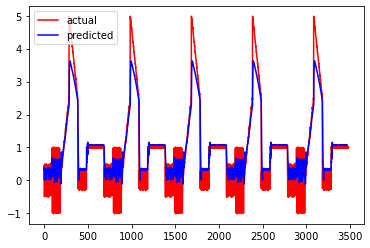

In [24]:
yh_train = model.predict(train_gen)
plt.plot(range(0,len(train_y)),train_y*3 ,label="actual",color="red")
plt.plot(range(0,len(yh_train)),yh_train*3,label="predicted",color="blue")
plt.legend(loc="upper left")
plt.show()

### Test fit

In [25]:
yh = model.predict(test_gen)

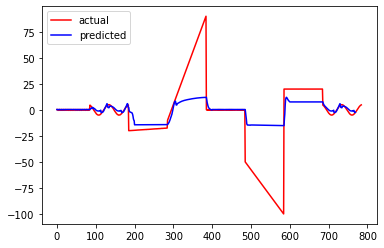

In [26]:
plt.plot(range(0,len(test_y)),test_y*3 ,label="actual",color="red")
plt.plot(range(0,len(yh)),yh*3,label="predicted",color="blue")
plt.legend(loc="upper left")
plt.show()

## Train OC 

In [27]:
extractor = tf.keras.Model(inputs=model.inputs,outputs=model.layers[-2].output)
print(extractor.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1)]           0         
_________________________________________________________________
rnn (RNN)                    (None, 128)               50560     
_________________________________________________________________
layer_normalization_1 (Layer (None, 128)               256       
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
layer_normalization_2 (Layer (None, 64)                128       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
Total params: 59,200
Trainable params: 59,200
Non-trainable params: 0
_______________________________________________________

In [28]:
X_train_oc = extractor.predict(train_gen)

In [29]:
X_train_oc.shape

(3470, 64)

In [30]:
def build_certificates(X, k=300, epochs=300):
    # build the model
    inputs = tf.keras.Input((64,))
    out = Dense(k, activation='linear',use_bias=False, name='certificates')(inputs)
    OC = tf.keras.models.Model(inputs=[inputs], outputs=out, name='ONC')
    
    # init the training loss object
    loss = tf.keras.metrics.Mean()
    loss_object = tf.keras.losses.MeanSquaredError()

    # init the optimization object
    optimizer = tf.keras.optimizers.Adam()
    
    for epoch in tqdm(range(epochs)):
        # Reset the metrics at the start of the next epoch
        loss.reset_states()

        # iterate over the data
        batches = int(np.floor(X.shape[0]/32))
        for i in range(batches):
            X_i = X[i*32:(i+1)*32]
            # init gradient tape
            with tf.GradientTape() as tape:
                # obtain the y_hat's
                y_hat = OC(X_i, training=True)

                # compute the loss
                error = tf.math.reduce_mean(tf.math.square(y_hat))
                error = tf.cast(error, dtype=tf.dtypes.float64)
                
                W = OC.layers[1].get_weights()[0] # Equation 4. 
                W = tf.linalg.matmul(tf.transpose(W),W)
                W = tf.cast(W, dtype=tf.dtypes.float64)
                
                penalty = tf.math.square(W - tf.eye(k,dtype=tf.dtypes.float64))
                penalty = tf.math.reduce_mean(penalty)
            
                error = error + penalty

            # calculate the gradients
            gradients = tape.gradient(error, OC.trainable_variables)
            # perform optimization on the gradients
            optimizer.apply_gradients(zip(gradients, OC.trainable_variables))
            
            # calculate and update the loss, metric
            loss.update_state(y_hat, y_hat) 
    
    # return the activations
    return OC

In [31]:
OC = build_certificates(X_train_oc)

100%|██████████| 300/300 [02:11<00:00,  2.28it/s]


## Evaluate OC over training data





In [43]:
X_test_oc = extractor.predict(test_gen)

In [44]:
# obtain the activations
scores = OC(X_test_oc)

# get the uncertainty
scores = tf.math.reduce_mean(tf.math.square(scores), axis=1).numpy()
scores = (scores - scores.min()) / (scores.max() - scores.min()) * 3

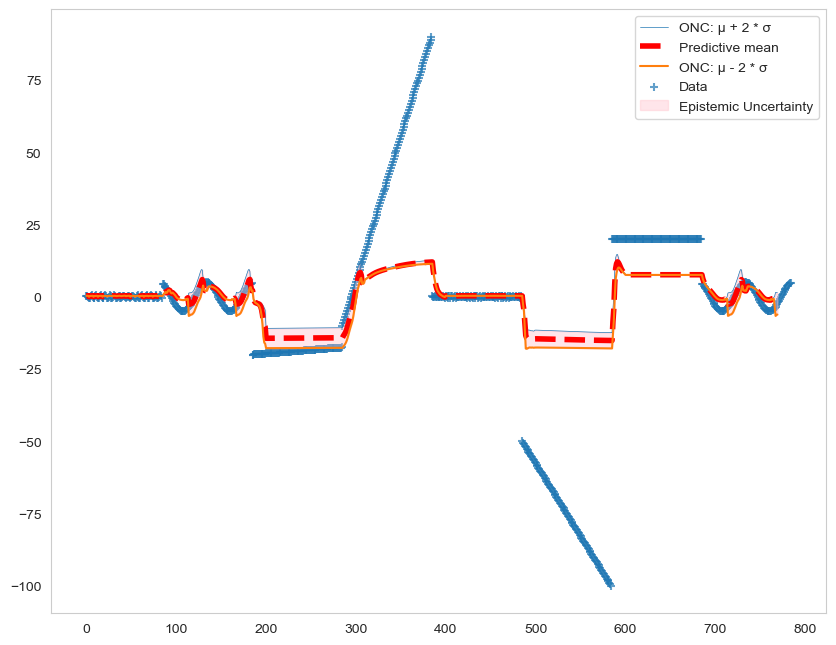

In [45]:
plt.figure(num=None, figsize=(10,8), dpi=100)
sns.set_style("whitegrid")
plt.rcParams['axes.prop_cycle']
sns.plotting_context("talk", rc={"lines.linewidth": 2})
plt.grid(b=False)

plt.plot(range(0,len(yh)), 3*yh.reshape(-1) + 2 * scores, label='ONC: μ + 2 * σ', linewidth=0.5)
plt.plot(range(0,len(yh)), 3*yh.reshape(-1), '--', label='Predictive mean', color='red', linewidth=4)
plt.plot(range(0,len(yh)), 3*yh.reshape(-1) -  2 * scores, label='ONC: μ - 2 * σ', linewidth=1.5)
plt.scatter(range(0,len(test_y)), 3*test_y, marker='+', label='Data', alpha=0.7)

plt.fill_between(np.array(range(0,len(yh))).ravel(), 
                 3*yh.reshape(-1) +  2 * scores, 
                 3*yh.reshape(-1) -  2 * scores, 
                 color='pink', alpha=0.4, label='Epistemic Uncertainty')

plt.legend();

## Train 1-Lipschitz Certificates 

In [35]:
class SpectralNormalization(tf.keras.layers.Wrapper):
    """Performs spectral normalization on weights.
    This wrapper controls the Lipschitz constant of the layer by
    constraining its spectral norm, which can stabilize the training of GANs.
    See [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957).
    ```python
    net = SpectralNormalization(
        tf.keras.layers.Conv2D(2, 2, activation="relu"),
        input_shape=(32, 32, 3))(x)
    net = SpectralNormalization(
        tf.keras.layers.Conv2D(16, 5, activation="relu"))(net)
    net = SpectralNormalization(
        tf.keras.layers.Dense(120, activation="relu"))(net)
    net = SpectralNormalization(
        tf.keras.layers.Dense(n_classes))(net)
    ```
    Arguments:
      layer: A `tf.keras.layers.Layer` instance that
        has either `kernel` or `embeddings` attribute.
      power_iterations: `int`, the number of iterations during normalization.
    Raises:
      AssertionError: If not initialized with a `Layer` instance.
      ValueError: If initialized with negative `power_iterations`.
      AttributeError: If `layer` does not has `kernel` or `embeddings` attribute.
    """

    @typechecked
    def __init__(self, layer: tf.keras.layers, power_iterations: int = 1, **kwargs):
        super().__init__(layer, **kwargs)
        if power_iterations <= 0:
            raise ValueError(
                "`power_iterations` should be greater than zero, got "
                "`power_iterations={}`".format(power_iterations)
            )
        self.power_iterations = power_iterations
        self._initialized = False

    def build(self, input_shape):
        """Build `Layer`"""
        super().build(input_shape)
        input_shape = tf.TensorShape(input_shape)
        self.input_spec = tf.keras.layers.InputSpec(shape=[None] + input_shape[1:])

        if hasattr(self.layer, "kernel"):
            self.w = self.layer.kernel
        elif hasattr(self.layer, "embeddings"):
            self.w = self.layer.embeddings
        else:
            raise AttributeError(
                "{} object has no attribute 'kernel' nor "
                "'embeddings'".format(type(self.layer).__name__)
            )

        self.w_shape = self.w.shape.as_list()

        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            trainable=False,
            name="sn_u",
            dtype=self.w.dtype,
        )

    def call(self, inputs, training=None):
        """Call `Layer`"""
        if training is None:
            training = tf.keras.backend.learning_phase()

        if training:
            self.normalize_weights()

        output = self.layer(inputs)
        return output

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(self.layer.compute_output_shape(input_shape).as_list())

    @tf.function
    def normalize_weights(self):
        """Generate spectral normalized weights.
        This method will update the value of `self.w` with the
        spectral normalized value, so that the layer is ready for `call()`.
        """

        w = tf.reshape(self.w, [-1, self.w_shape[-1]])
        u = self.u

        with tf.name_scope("spectral_normalize"):
            for _ in range(self.power_iterations):
                v = tf.math.l2_normalize(tf.matmul(u, w, transpose_b=True))
                u = tf.math.l2_normalize(tf.matmul(v, w))

            sigma = tf.matmul(tf.matmul(v, w), u, transpose_b=True)

            self.w.assign(self.w / sigma)
            self.u.assign(u)

    def get_config(self):
        config = {"power_iterations": self.power_iterations}
        base_config = super().get_config()
        return {**base_config, **config}

In [36]:
def build_1_Lipschitz(X, k=300, epochs=300):
    # build the model
    inputs = tf.keras.Input((64,))
    out = SpectralNormalization(Dense(k, activation='linear',use_bias=False, name='certificates'))(inputs)
    OC = tf.keras.models.Model(inputs=[inputs], outputs=out, name='ONC')
    
    # init the training loss object
    loss = tf.keras.metrics.Mean()
    loss_object = tf.keras.losses.MeanSquaredError()

    # init the optimization object
    optimizer = tf.keras.optimizers.Adam()
    
    for epoch in tqdm(range(epochs)):
        # Reset the metrics at the start of the next epoch
        loss.reset_states()

        # iterate over the data
        batches = int(np.floor(X.shape[0]/32))
        for i in range(batches):
            X_i = X[i*32:(i+1)*32]
            # init gradient tape
            with tf.GradientTape() as tape:
                # obtain the y_hat's
                y_hat = OC(X_i, training=True)

                # compute the loss
                error = tf.math.reduce_mean(tf.math.square(y_hat))
                error = tf.cast(error, dtype=tf.dtypes.float64)

            # calculate the gradients
            gradients = tape.gradient(error, OC.trainable_variables)
            # perform optimization on the gradients
            optimizer.apply_gradients(zip(gradients, OC.trainable_variables))
            
            # calculate and update the loss, metric
            loss.update_state(y_hat, y_hat) 
    
    # return the activations
    return OC

In [37]:
lipOC = build_1_Lipschitz(X_train_oc)

100%|██████████| 300/300 [01:41<00:00,  2.95it/s]


In [46]:
# obtain the activations
scores = lipOC(X_test_oc)

# get the uncertainty
scores = tf.math.reduce_mean(tf.math.square(scores), axis=1).numpy()
scores = (scores - scores.min()) / (scores.max() - scores.min()) * 3

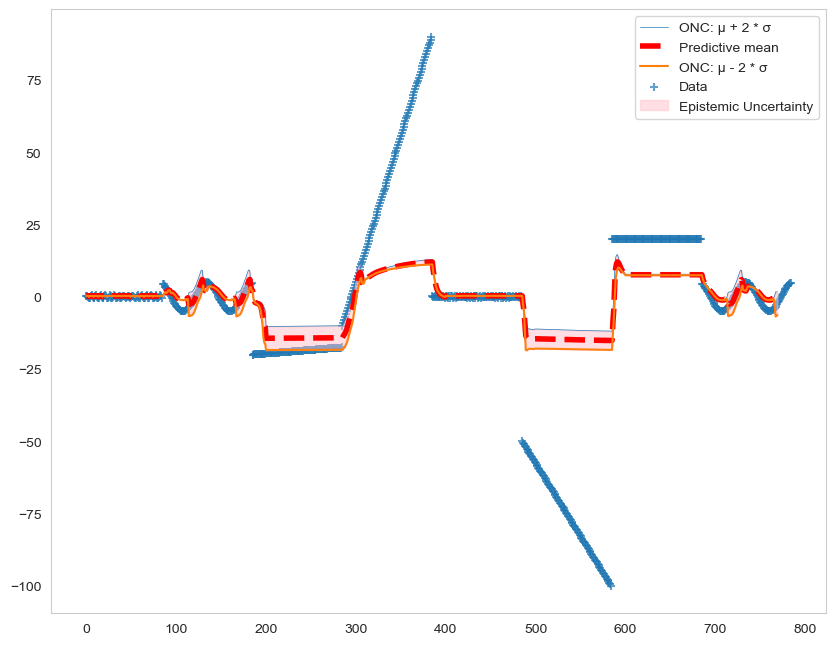

In [47]:
plt.figure(num=None, figsize=(10,8), dpi=100)
sns.set_style("whitegrid")
plt.rcParams['axes.prop_cycle']
sns.plotting_context("talk", rc={"lines.linewidth": 2})
plt.grid(b=False)

plt.plot(range(0,len(yh)), 3*yh.reshape(-1) +  2 * scores, label='ONC: μ + 2 * σ', linewidth=0.5)
plt.plot(range(0,len(yh)), 3*yh.reshape(-1), '--', label='Predictive mean', color='red', linewidth=4)
plt.plot(range(0,len(yh)), 3*yh.reshape(-1) -  2 * scores, label='ONC: μ - 2 * σ', linewidth=1.5)
plt.scatter(range(0,len(test_y)), 3*test_y, marker='+', label='Data', alpha=0.7)

plt.fill_between(np.array(range(0,len(yh))).ravel(), 
                 3*yh.reshape(-1) +  2 * scores, 
                 3*yh.reshape(-1) -  2 * scores, 
                 color='pink', alpha=.5, label='Epistemic Uncertainty')

plt.legend();